In [1]:
# refer from Mish https://github.com/digantamisra98/Mish/blob/master/Layers_Acc.ipynb
# SwishT (ours) vs Mish, Swish, GELU, etc 

import sys
sys.path.append('../')
import easydict # pip install easydict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc

# external location
from experiments.activation.acts import *
from experiments.data.datasets import MNIST,CIFAR10,CIFAR100


In [9]:
# Configs
conf = easydict.EasyDict()
# MNNSIT
# conf.batchsize = [2,32,128,384,512,1024,2048,3072,4096][::-1]
# cifar10
conf.batchsize = [2,32,128,384,512,1024,2048,][::-1]
conf.num_classes = 10
conf.epochs = 10

In [12]:
class CustomCNN(nn.Module):
    def __init__(self, num_layers, num_classes=10,activation=None,hidden_uints=512):
        super(CustomCNN, self).__init__()
        # Define the initial convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Assuming input is 1 channel (MNIST)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.act = activation
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fcs_init = nn.Linear(64 * 16 * 16, hidden_uints) 
        self.fcs = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_uints, hidden_uints),  
            nn.BatchNorm1d(hidden_uints),
            self.act,
            nn.Dropout(0.25)
        ) for i in range(num_layers-1)])
        # Final layer
        self.final_fc = nn.Linear(hidden_uints, num_classes)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fcs_init(x)
        for fc in self.fcs:
            x = fc(x)
        x = self.final_fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch,verbose=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')

    return test_acc

def model_relu(batch_size = 128,num_layers=16,activation=None,epochs=10,lr=0.01):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    print(device)
    trainloader = DataLoader(CIFAR10(train=True),batch_size=batch_size,num_workers=2 if batch_size < 128 else 0) 
    testloader = DataLoader(CIFAR10(train=False),batch_size=1024,num_workers=2 if batch_size < 128 else 0)
    model = CustomCNN(num_layers=num_layers,num_classes=10,activation=activation)
    model.to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=lr)

    best_acc = -1
    for epoch in range(epochs):
        print(epoch,' training..')
        train(model,device=device,train_loader=trainloader,optimizer=optimizer,epoch=epoch)
        test_acc = test(model,device,test_loader=testloader)
        if test_acc > best_acc:
            best_acc = test_acc
    
    return best_acc

def plot_result(results,labels,desc='Testing Accuracy vs Batch size on CIFAR10',exp='Number of Batch size'):
    positions = list(range(len(labels))) 
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    for name, data in results.items():
        plt.plot(data,'-o', label= name)
    plt.legend(loc='best', fontsize=15)
    plt.xticks(positions, labels)
    plt.grid()
    plt.xlabel(exp, fontsize = 20)
    plt.ylabel('Testing Accuracy', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.title.set_text(desc)
    ax.title.set_fontsize(20)
    plt.savefig("layersacc.png", bbox_inches = 'tight')
    plt.show()

In [13]:
results = {}
activations = {
  'Mish':Mish(),
  'SwishT':SwishT(beta_init=0.1,alpha=0.01),
  'Swish':Swish(),
  'GELU':nn.GELU(),
  'ReLU':nn.ReLU(),
}
range_batch = conf.batchsize
for name,act in activations.items():
  print(name,end=' ')
  results[name] = []
  
  for n in range_batch:
    print(n,' batch')
    test_acc = model_relu(batch_size=n,activation=act,epochs=conf.epochs)
    results[name].append(test_acc)
    print(results)
    plot_result(results,labels=range_batch)
    
  
    

Mish 2048  batch
cuda:0
0  training..

Test set: Average loss: 2.3143, Accuracy: 1000/10000 (10%)

1  training..

Test set: Average loss: 2.3565, Accuracy: 1000/10000 (10%)

2  training..


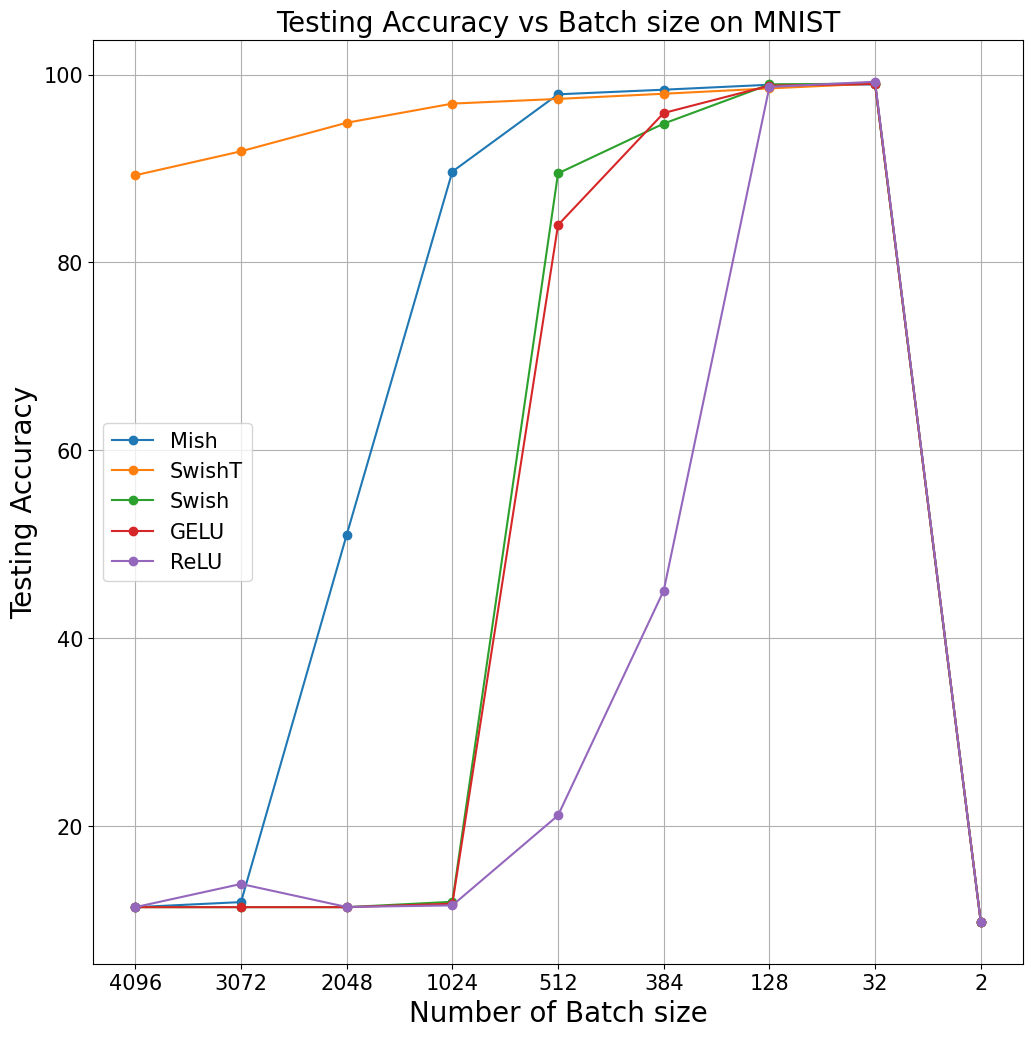

In [8]:
plot_result(results,labels=conf.batchsize,desc='Testing Accuracy vs Batch size on MNIST')